# SET PARAMETERS BELOW

In [11]:
from clic_photo import*

parameters = {

    "fp file path": r"C:\Users\class\Dropbox\Clic workspace\Individual personal drives\Dhaval Joshi individual drive\FP Pilots - 4, 10, 12\3 - B2_288 - Jan2022\Photometry Data\Stimuli Challenge\Photometry_CS and tone 2022-04-04 Rats3_4", #path of the csv file produced by the Neurophotometrics Bonsai Workflow
    "signal column": "Region1G", #column name for the raw signal (this applies for raw datafiles containing interleaved data)
    "timestamp column": "Timestamp", #column name containing the time stamps
    "isosbestic flag": 1, #LedState column value that represent the isosbestic signals
    "gcamp flag": 2, #LedState column value that represent the Ca-dependent signals

    "event file path": r"C:\Users\class\Dropbox\Clic workspace\Individual personal drives\Dhaval Joshi individual drive\FP Pilots - 4, 10, 12\3 - B2_288 - Jan2022\Photometry Data\Stimuli Challenge\Box3_CS and tone 2022-04-04 Rat4", #path of the csv file that records the timestamps of behavioural events of interest.
    "event column": "cs", #name of the column in the behavioural events file that records the value of the event of interest being "on" and "off"
    "event time column": "tone.Timestamp", #name of the column in the behavioural events file that records the timestamps
    "snip window": (3, 5), #inside the brackets enter how many seconds before and after each event you want to include in the PSTH
    "snip baseline window": (3,0),
    
    "rolling window" : 500, #number of samples used in the calculation of rolling median to evaluate the modified z-score
    "artifact threshold": 5, #threshold median absolute deviation value for detecting artifacts in the raw fluorescence data
    "spike threshold": 3, #threshold median absolute deviation value for detecting spikes in the z-score
    "gaussian sigma": 5, #sigma parameter for the Gaussian filter applied on the 

    "time bin length": 60, #specify bin length in seconds in case you want to label time bins in your data
    "session length": 1200, #specify session length in seconds

}

# PRODUCE MASTER DATAFRAME WITH PHOTOMETRY DATA OF THE WHOLE RECORDING SESSION

### The process_rawdata() function

In [12]:
help(process_rawdata)

Help on function process_rawdata in module clic_photo:

process_rawdata(filepath, signalcol, timecol, iso_flag, gcamp_flag, session_length, artifact_threshold, gaussian_sigma, rolling_window, bleach_correction=False)
    Takes the interleaved photometry CSV file and produces a master dataframe with the raw signal corrected for bleaching, filtered for artifacts and then converted to deltaF/F. The zscore is calculcated over a moving window passed over the deltaF/F.



In [13]:
master_df = process_rawdata(parameters["fp file path"],
                            parameters["signal column"],
                            parameters["timestamp column"],
                            parameters["isosbestic flag"],
                            parameters["gcamp flag"],
                            parameters["session length"],
                            parameters["artifact threshold"],
                            parameters["gaussian sigma"],
                            parameters["rolling window"])

add_bins(master_df, parameters["time bin length"])

# if the master_df dataframe is required to be exported, un-comment the appropriate line below

# master_df.to_csv("master dataframe.csv") # to save as a CSV file
# master_df.to_excel("master dataframe.xlsx") # to save as an xlsx file

### Visualise the signal and its iterations through the pipeline: filtering, evaluation of deltaF/F and then z-score

Text(0.5, 0, 'Time (s)')

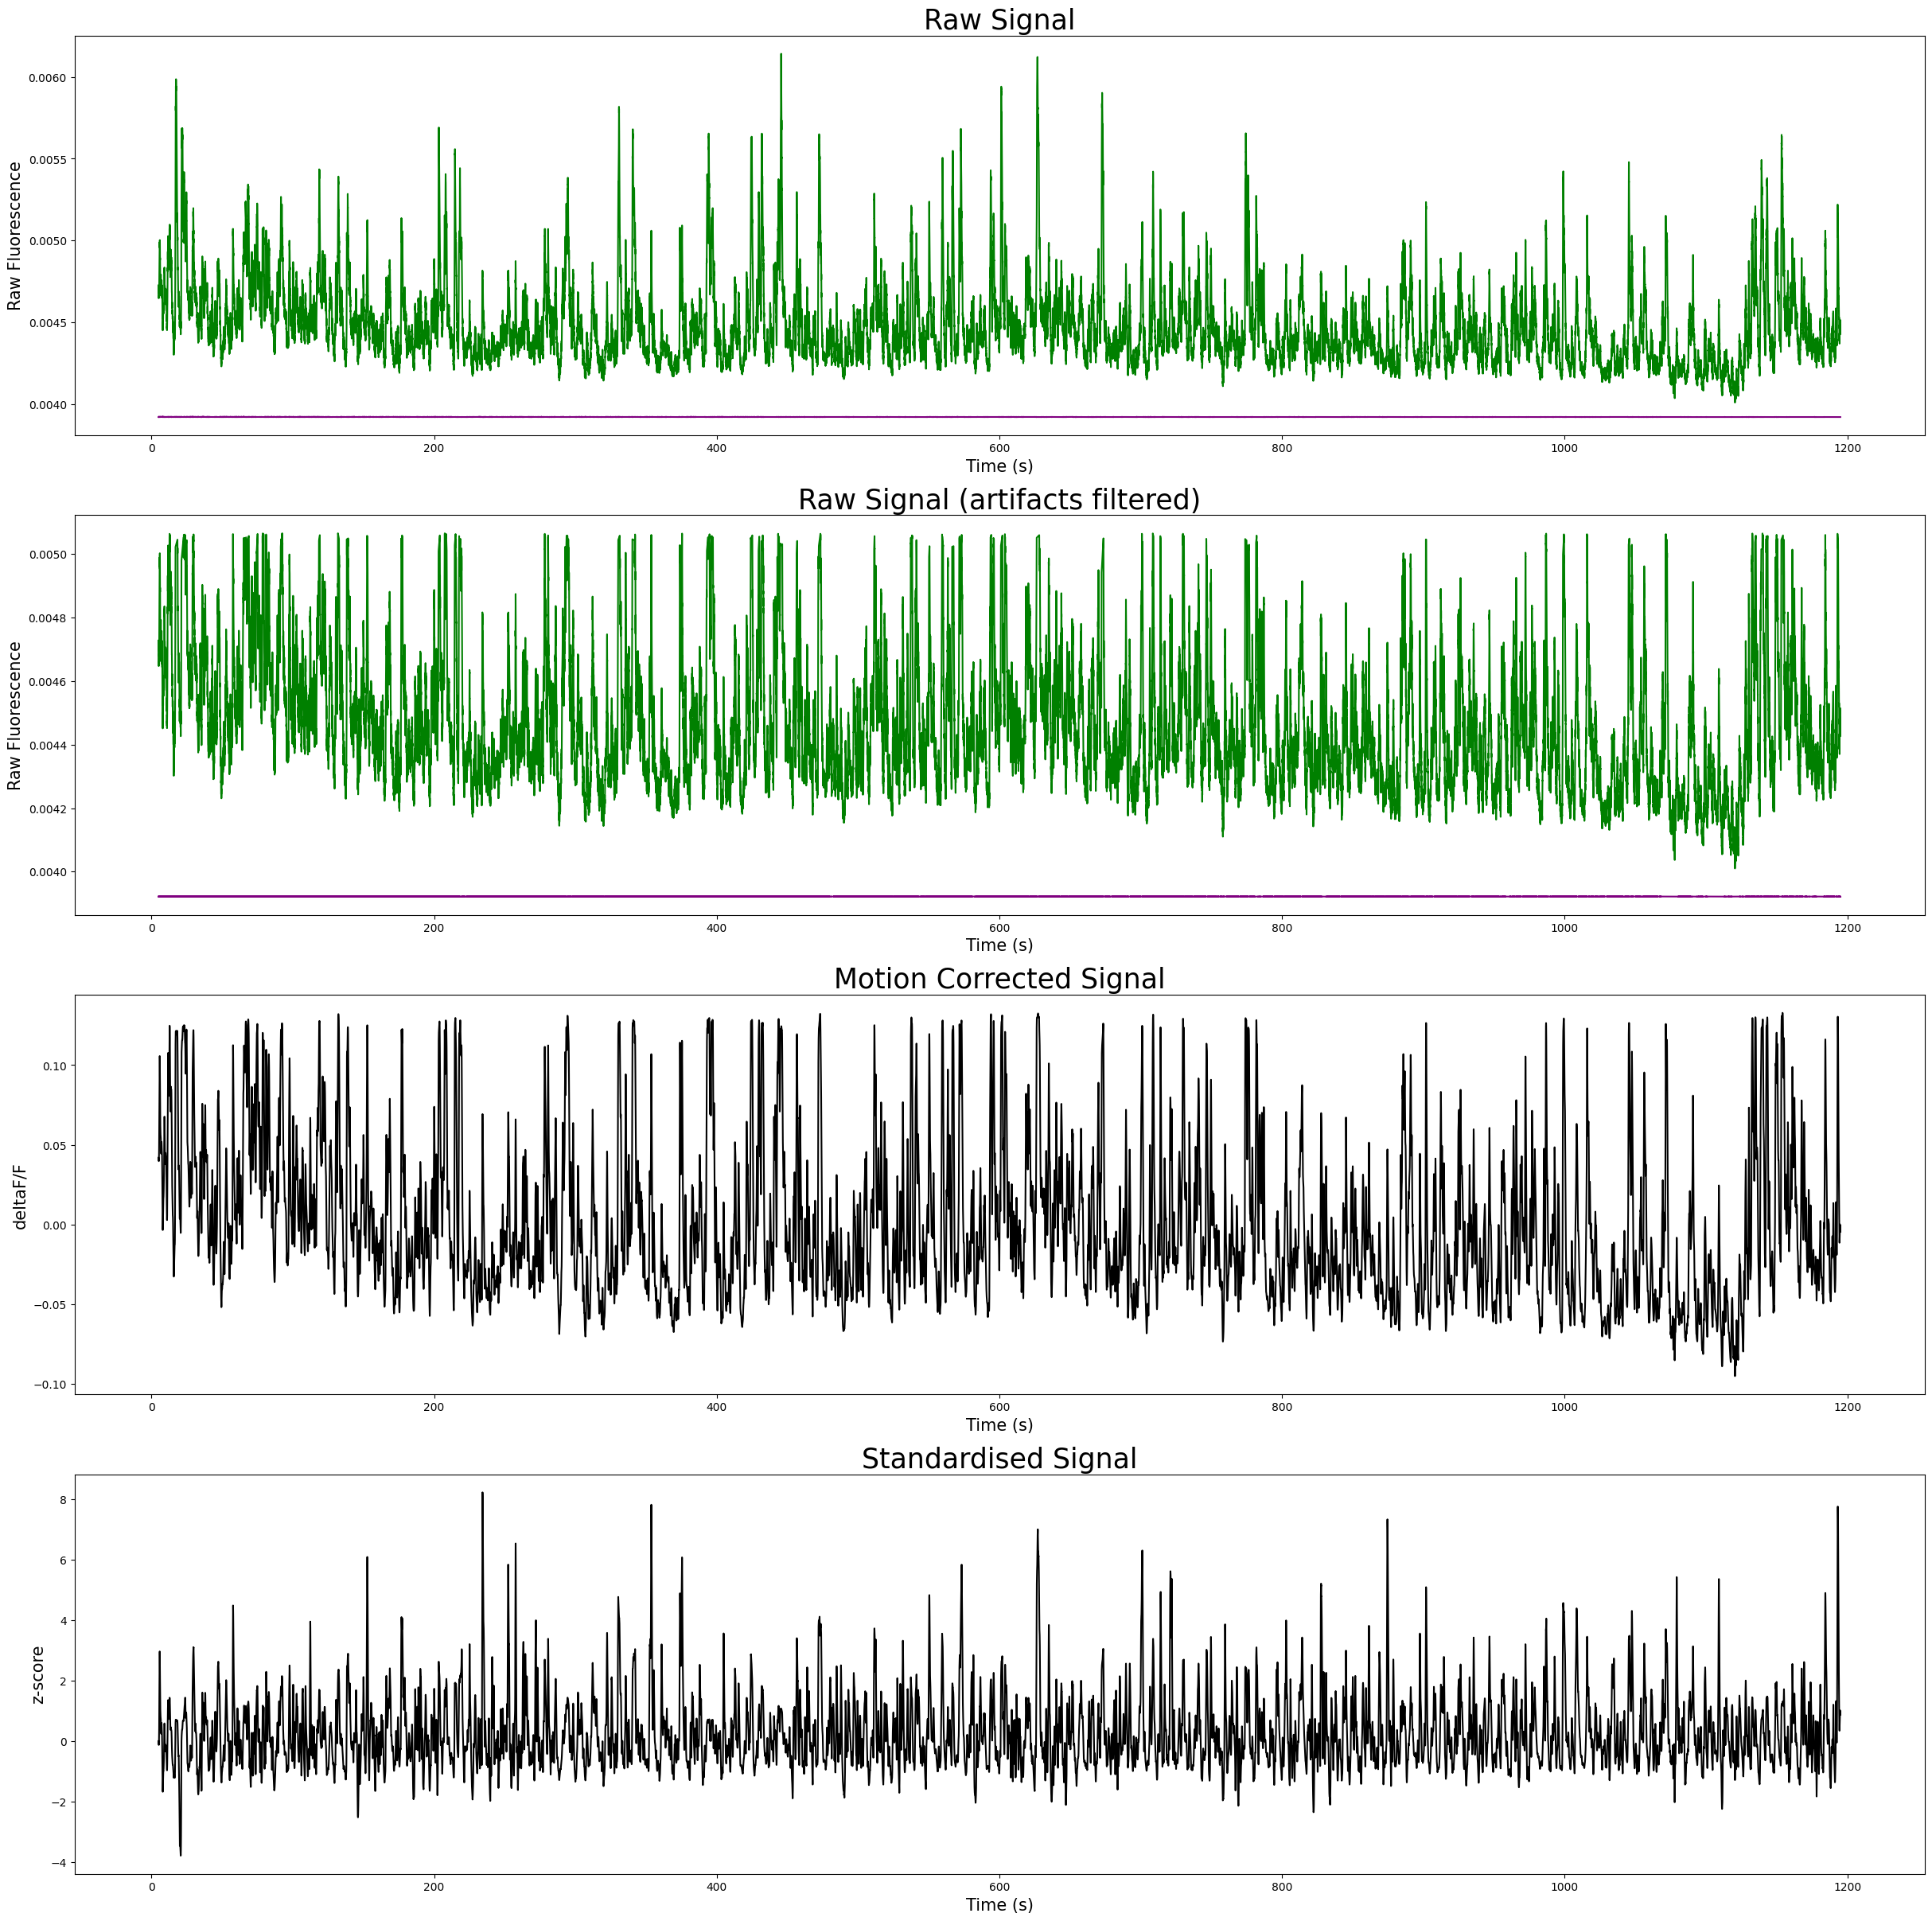

In [14]:
plt.figure(figsize=(30,30))

plt.subplot(411)
plt.title("Raw Signal", fontsize = 25)
sns.lineplot(data = master_df, x = "iso time", y = "iso signal raw", color = "purple")
sns.lineplot(data = master_df, x = "gcamp time", y = "gcamp signal raw", color = "green")
plt.ylabel("Raw Fluorescence", fontsize = 15)
plt.xlabel("Time (s)", fontsize = 15)

plt.subplot(412)
plt.title("Raw Signal (artifacts filtered)", fontsize = 25)
sns.lineplot(data = master_df, x = "iso time", y = "iso signal", color = "purple")
sns.lineplot(data = master_df, x = "gcamp time", y = "gcamp signal", color = "green")
plt.ylabel("Raw Fluorescence", fontsize = 15)
plt.xlabel("Time (s)", fontsize = 15)

plt.subplot(413)
plt.title("Motion Corrected Signal", fontsize = 25)
sns.lineplot(data = master_df, x = "gcamp time", y = "gcamp dff", color = "k")
plt.ylabel("deltaF/F", fontsize = 15)
plt.xlabel("Time (s)", fontsize = 15)

plt.subplot(414)
plt.title("Standardised Signal", fontsize = 25)
sns.lineplot(data = master_df, x = "gcamp time", y = "gcamp zscore", color = "k")
plt.ylabel("z-score", fontsize = 15)
plt.xlabel("Time (s)", fontsize = 15)

# POPULATE THE MASTER DATAFRAME WITH SPIKE AND WAVE STATISTICS, EXPORT A DATAFRAME WITH INFORMATION ON EACH SPIKE, EACH WAVE AND WAVE STATISTICS SUMMARISED BY TIME BIN

### The peaky_finder() function - outputs 4 dataframes

In [15]:
help(peaky_finder)

Help on function peaky_finder in module clic_photo:

peaky_finder(input_df, spike_threshold, signal='gcamp')
    Takes the master dataframe of the dff and zscores to evaluate spikes and waves that occur around each spike.



In [5]:
master_df, spike_df, wave_df, bin_df = peaky_finder(master_df, parameters["spike threshold"])

# GENERATE PSTH DATA BY SNIPPING THE dF/F SIGNAL AROUND A TIMELOCKED EVENT OF INTEREST

### The gen_psth() function - outputs the dataframe of each event ocurrence and snips of zscore about each event

In [6]:
help(gen_psth)

Help on function gen_psth in module clic_photo:

gen_psth(fp_df, event_file_path, event_col, event_timecol, snip_window, baseline_zscore=False, baseline_window=None)
    Takes the dataframe from the master dataframe created from the process_rawdata() function and snips the deltaF/F around an event from interest specified from the csv file with timestamps of behavioural events.



In [7]:
snip = gen_psth(master_df,
                parameters["event file path"],
                parameters["event column"], 
                parameters["event time column"],
                parameters["snip window"])